In [1]:
# import required package
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# load train and test data
# data already splitted, used the first four years (2011-2014) of data as 
# trainning data, and test the model on the last year of data (2015)

train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/gt_2015.csv')

train_features = train_df.copy()
test_features = test_df.copy()

train_labels_CO = train_features.pop('CO')
test_labels_CO = test_features.pop('CO')
train_labels_NOX = train_features.pop('NOX')
test_labels_NOX = test_features.pop('NOX')

train_df.describe().transpose()[['mean', 'std']]

,mean,std
AT,17.835369,7.270248
AP,1012.708137,6.298584
AH,80.186589,13.742408
AFDP,4.007690,0.788930
GTEP,25.421312,4.110938
TIT,1082.045341,16.874589
TAT,546.036755,7.137500
TEY,133.383884,15.472271
CDP,12.051342,1.076259
CO,2.181882,2.229464


In [3]:
# normalizer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

# first feature normalized
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

2021-11-09 16:08:32.132024: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[  17.835373 1012.70776    80.18655     4.007695   25.42132  1082.0455
   546.0367    133.38403    12.051332]]
First example: [[   4.59 1018.7    83.67    3.58   23.98 1086.2   549.83  134.67   11.9 ]]

Normalized: [[-1.82  0.95  0.25 -0.55 -0.35  0.25  0.53  0.08 -0.14]]


In [4]:
# Linear Regression with multiple features with normalizer
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(train_features[:10])

# compile the model
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')

def plot_loss_CO(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [CO]')
  plt.legend()
  plt.grid(True)

def plot_loss_NOX(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [NOX]')
  plt.legend()
  plt.grid(True)


In [5]:
# CO
history_CO = linear_model.fit(
    train_features,
    train_labels_CO,
    epochs=50,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

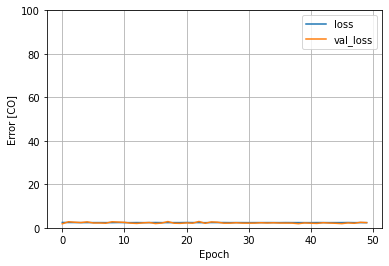

In [6]:
plot_loss_CO(history_CO)

test_results = {}
test_results['linear_model_CO'] = linear_model.evaluate(
    test_features, test_labels_CO, verbose=0)

In [7]:
# NOX
history_NOX = linear_model.fit(
    train_features,
    train_labels_NOX,
    epochs=50,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

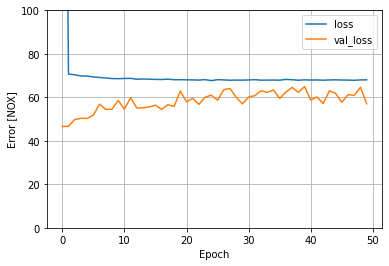

In [8]:
plot_loss_NOX(history_NOX)

test_results['linear_model_NOX'] = linear_model.evaluate(
    test_features, test_labels_NOX, verbose=0)

In [9]:
# Regression with DNN
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(100, activation='relu', input_dim=9),
      layers.Dense(50, activation='relu'),
      layers.Dense(20, activation='softmax')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

dnn_history_CO = dnn_model.fit(
    train_features,
    train_labels_CO,
    validation_split=0.2,
    verbose=0, epochs=100)

dnn_history_NOX = dnn_model.fit(
    train_features,
    train_labels_NOX,
    validation_split=0.2,
    verbose=0, epochs=100)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 100)               1000      
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 20)                1020      
                                                                 
Total params: 7,089
Trainable params: 7,070
Non-trainable params: 19
_________________________________________________________________


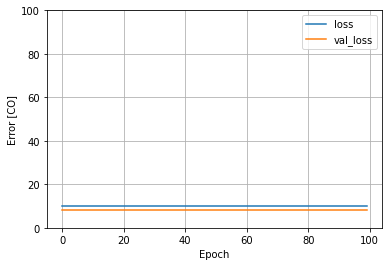

In [10]:
plot_loss_CO(dnn_history_CO)
test_results['dnn_model_CO'] = dnn_model.evaluate(test_features, test_labels_CO, verbose=0)

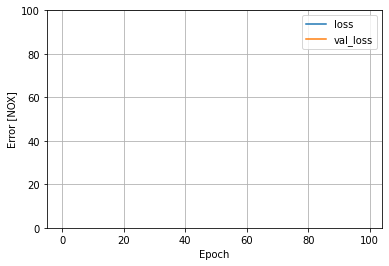

In [11]:
plot_loss_NOX(dnn_history_NOX)
test_results['dnn_model_NOX'] = dnn_model.evaluate(test_features, test_labels_NOX, verbose=0)

In [12]:
# Performance
pd.DataFrame(test_results, index=['Mean squared error']).T

,Mean squared error
linear_model_CO,4.359887
linear_model_NOX,124.454506
dnn_model_CO,14.480695
dnn_model_NOX,3704.802002
